<a href="https://colab.research.google.com/github/thibaud-perrin/diffusion-model/blob/main/diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Model

## imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_checkerboard, make_circles ,make_moons, make_s_curve, make_swiss_roll
from PIL import Image
import matplotlib.pyplot as plt
import torch

In [2]:
plt.rcParams.update({
    "figure.facecolor":  (0, 0, 0, 1),
    "axes.facecolor":    (0.0, 0, 0.0, 1),
    "savefig.facecolor": (0.0, 0.0, 0, 1),
})

## Loading data
### swiss_roll

In [3]:
swiss_roll, _ = make_swiss_roll(10**4,noise=0.1)
swiss_roll = swiss_roll[:, [0, 2]]/10.0
swiss_roll.shape

(10000, 2)

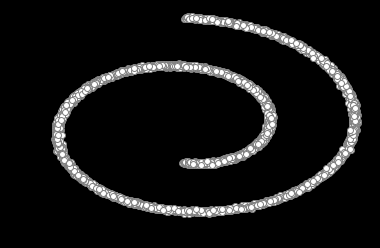

In [21]:
plt.scatter(swiss_roll[:, 0], swiss_roll[:, 1], c='w', edgecolor='gray')

### Curve

In [5]:
s_curve, _= make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0
s_curve.shape

(10000, 2)

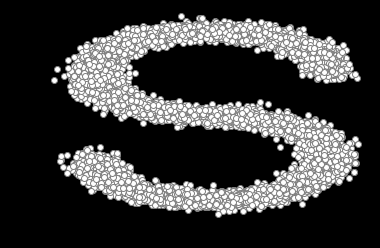

In [22]:
plt.scatter(s_curve[:, 0], s_curve[:, 1], c='w', edgecolor='gray')

### Moon

In [7]:
moons, _ = make_moons(10**4, noise=0.1)
moons.shape

(10000, 2)

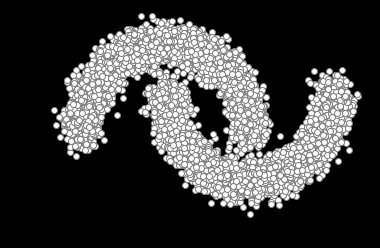

In [20]:
plt.scatter(moons[:, 0], moons[:, 1], c='w', edgecolor='gray')

## Utils

In [9]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

In [10]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

## Forward Diffusion

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}}\mathbf{x}_{t-1},\beta_{t}\mathbf{I})
$$

Substituting $\alpha_{t}=1-\beta_{t}$ and $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$: 

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{t-1},(1-\bar{\alpha}_{t})\mathbf{I})
$$

Given the initial state, this makes it possible to draw sample at any desrired timestep without going through intermediate steps. Forward diffusion can also be written in terms of $x_0$ and the random noise $\epsilon \sim \mathcal{N}(0,1)$.

$$
x_t(x_0,\epsilon) = \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1-\bar{\alpha_{t}}}\epsilon          
$$

In [11]:
dataset = torch.Tensor(moons.T).float()

In [12]:
num_steps = 100
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [13]:
def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

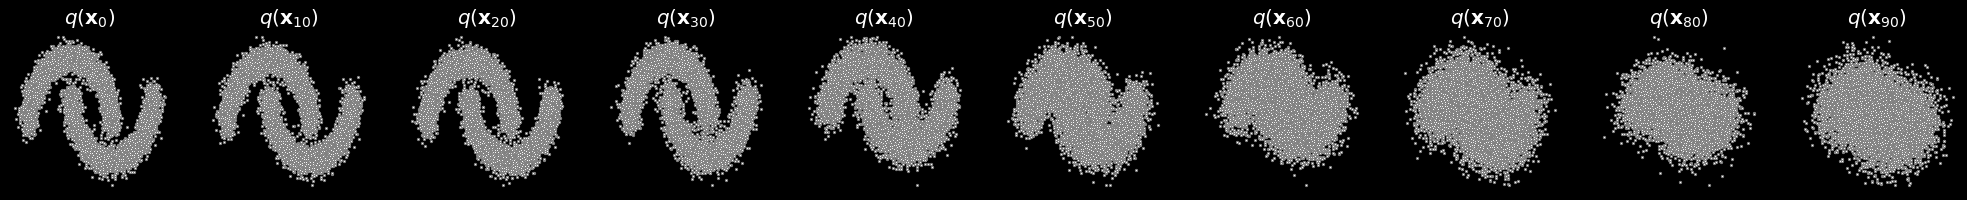

In [24]:
fig, axs = plt.subplots(1, 10, figsize=(35, 3))
for i in range(10):
    q_i = q_x(dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[0, :], q_i[1, :], c='w', edgecolor='gray', s=5);
    axs[i].set_axis_off()
    axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$', c='w', fontsize=20)

In [14]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

In [ ]:
def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var